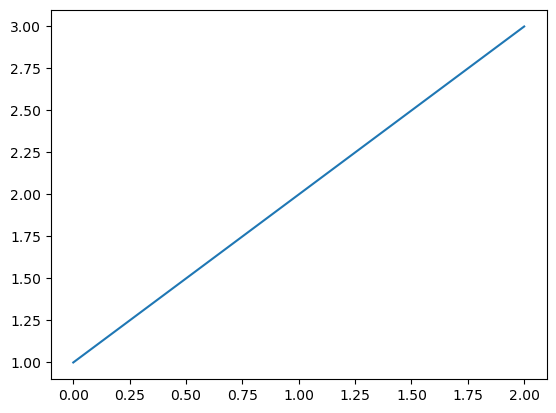

In [1]:
import matplotlib.pyplot as plt

plt.plot([1,2,3])

In [2]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import os
from torchvision import io
import pickle
import sys
import numpy as np
from torch import nn

In [5]:
class BaseHISDataset(Dataset):
    def __init__(self, 
                 images_dir: str,
                 annotations_dir: str):
        """Base loader for hierarchical dataset

        Args:
            images_dir (str): path to source images folder
            annotations_dir (str): path to annotation tree folder            
        """
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.images = os.listdir(images_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # read image
        image = io.read_image(str(Path(self.images_dir) / self.images[index])).float()
        image /= 255
        
        
        # read annotations
        with open(str(Path(self.annotations_dir) /
                  self.images[index].replace(".png", ".pkl")), "rb") as f:
            annotation = pickle.load(f)
            

        return image, annotation

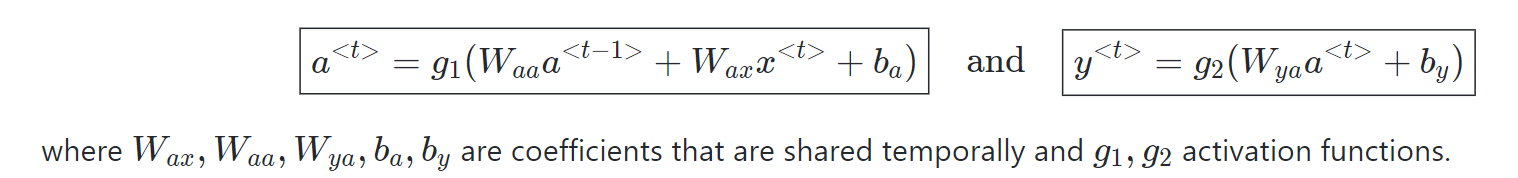

In [6]:
class UnitProcess(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels*2, 3, 1, 1),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(),
        #   nn.Conv2d(in_channels*2, in_channels*4, 3, 1, 1),
        #   nn.BatchNorm2d(in_channels*4),
        #   nn.ReLU(),
          nn.Conv2d(in_channels*2, in_channels*2, 3, 1, 1),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(),
          nn.Conv2d(in_channels*2, out_channels, 3, 1, 1),
        )
        
        
    def forward(self, x):
        return self.process(x)
    

class RCNNCell(nn.Module):
    def __init__(self, in_channels, height, width, out_channels=1):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden state
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden', torch.ones(1, in_channels, height, width))
        self.hidden = self.hidden.to("cuda")
        
        # output generation
        self.Wya = UnitProcess(in_channels, out_channels).to("cuda")
        
        # hidden state processing  
        self.Waa = UnitProcess(in_channels, in_channels).to("cuda")
        self.Wax = UnitProcess(in_channels, in_channels).to("cuda")
        
        # self.bias_x = nn.Parameter(torch.randn(1, in_channels, height, width)).to("cuda")
        # self.bias_y = nn.Parameter(torch.randn(1, out_channels, height, width)).to("cuda")
        
        
    def forward(self, x):
        # calculate state
        hidden_batched = self.hidden.expand(x.shape[0], -1, -1, -1)  
        # hidden_batched = self.hidden
        
        self.hidden = nn.functional.relu(self.Waa(hidden_batched) + self.Wax(x))# + self.bias_x)
        
       
        # calculate output
        x = nn.functional.relu(self.Wya(self.hidden))# + self.bias_y)
        
        return x
    
    def resetState(self):
        self.hidden = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

In [7]:
class RCNN(nn.Module):
    def __init__(self, rcnn_cell, n_cells, in_channels, height, width, out_channels=1):
        super().__init__()
        
        self.n_cells = n_cells
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = 1
        
        self.rcnn_cells = nn.ModuleList()
        for i in range(n_cells):
            if i == 0:
                c = in_channels
            else:
                c = out_channels
            self.rcnn_cells.append(rcnn_cell(c, height, width, out_channels))
        
        
    def forward(self, x):
        """
        x: list of tokens (c, h, w)
        """
        # reset all cell states for new input
        for cell in self.rcnn_cells:
            cell.resetState()
        
        # keep feed layer output to next layer
        layer_input = x
        layer_output = []
        for i, cell in enumerate(self.rcnn_cells):
            # generating output for nth cell
            for input_t in layer_input:
                layer_output.append(cell(input_t))
                
            # output becomes input
            layer_input = layer_output
            if i+1 < len(self.rcnn_cells):
                layer_output = []
                
        return layer_output

In [22]:
# test
model = RCNN(rcnn_cell=lambda *x: RCNNCell(*x),
             n_cells=4,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
[i.shape for i in model([torch.randn(1, 3, 200, 200).to("cuda") for _ in range(3)])]

[torch.Size([1, 1, 200, 200]),
 torch.Size([1, 1, 200, 200]),
 torch.Size([1, 1, 200, 200])]

In [128]:
# test
model = RCNNCell(10, 200, 200)
model(torch.randn(10, 10, 200, 200).to("cuda")).shape

torch.Size([10, 1, 200, 200])

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [7]:
dataset = BaseHISDataset("../data/dataset_3/data/", "../data/dataset_3/RCNNAnnotations/")
train_dataset, val_dataset = random_split(
    dataset, [45, 5], torch.Generator().manual_seed(10)
)

In [7]:
import random
from torchvision.transforms import v2
from torchvision import tv_tensors

transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomResizedCrop((200, 200)),
    # v2.ColorJitter(0.1)
    v2.RandomRotation(10)
])

# RNNCell

In [232]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RCNNCell(3, 200, 200).to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5).to("cuda"))
in_channels = 3
height = 200
width = 200

In [74]:
writer = SummaryWriter(f"./runs/RCNN/r1", comment="RCNN")

In [242]:
for e in range(200):
    
    epoch_loss = 0
    
    for data in train_dataset:
        image, annotation = data
        image = image.to(device).unsqueeze(dim=0)
        
        # reset state
        model.hidden = torch.ones(1, in_channels, height, width).to("cuda")
        
        # pass input
        optimizer.zero_grad()
        
        output = model(image)
        
        l = 0
        
        for weight, ann in enumerate(annotation):
            ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0)
            l += loss(output, ann) #* (weight+1)
            
            output = model(image)
            
        l.backward()
            
        optimizer.step()
        
        epoch_loss += l 
    
    writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"Epoch {e}: {epoch_loss}")

Epoch 0: 137.79226028475685
Epoch 1: 137.82710436842623
Epoch 2: 137.76419061707105
Epoch 3: 137.76815529506422
Epoch 4: 137.7371416325752
Epoch 5: 137.74520483581088
Epoch 6: 137.71060845798624
Epoch 7: 137.72464848856544
Epoch 8: 137.69364925778416
Epoch 9: 137.67409061520172
Epoch 10: 137.64515692564459
Epoch 11: 137.64946180668795
Epoch 12: 137.6270236383583
Epoch 13: 137.59980400823625
Epoch 14: 137.6146883723547
Epoch 15: 137.58208359246552
Epoch 16: 137.600121396041
Epoch 17: 137.5245300701217
Epoch 18: 137.52255779301487
Epoch 19: 137.52753059769242
Epoch 20: 137.49387842171728
Epoch 21: 137.48769214548045
Epoch 22: 137.49117475913687
Epoch 23: 137.45607282250822
Epoch 24: 137.4487789186144
Epoch 25: 137.4219639399367
Epoch 26: 137.43070627081738
Epoch 27: 137.41165404477965
Epoch 28: 137.37957448669243
Epoch 29: 137.38097679427096
Epoch 30: 137.33347428341773
Epoch 31: 137.34438825298392
Epoch 32: 137.34615543330943
Epoch 33: 137.2941378541436
Epoch 34: 137.28777682303624
Epoc

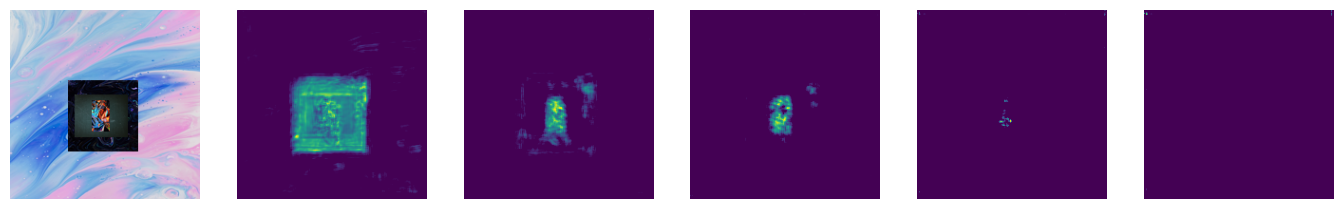

In [244]:
with torch.inference_mode():
    image, annotation = train_dataset[7]
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 7, 1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    image = (image).unsqueeze(dim=0).to("cuda")
    
    model.hidden = torch.ones(1, in_channels, height, width).to("cuda")
    for i in range(5):
        plt.subplot(1, 7, i+2)
        output = model(image)
        
        plt.imshow(output.detach().cpu().squeeze())
        # plt.imshow(annotation[i])
        plt.axis("off")

# RCNN Group

In [7]:
dataset = BaseHISDataset("../data/dataset_2/data/", "../data/dataset_2/RCNNAnnotations/")
train_dataset, val_dataset = random_split(
    dataset, [45, 5], torch.Generator().manual_seed(10)
)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RCNN(rcnn_cell=lambda *x: RCNNCell(*x),
             n_cells=2,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.).to("cuda"))
in_channels = 3
height = 200
width = 200
writer = SummaryWriter(f"./runs/RCNNGroup/d2/r2", comment="RCNN, batch increasing, nested loss")

training loop

In [30]:
batch_size = 1
for e in range(50):
    
    epoch_loss = 0
    optimizer.zero_grad()
    for b, data in enumerate(train_dataset):
        image, annotation = data
    
        # pass input
        optimizer.zero_grad()
        
        image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
        
        output = model(image)
        
        # compute loss
        l = 0
        for i, ann in enumerate(annotation):
            loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float((i+1))).to("cuda"))
            ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
            l += loss(output[i], ann) #* (weight+1)
            
        
        # print(b)
        l.backward()
        
        # print(f"{b}%{batch_size} = {i%batch_size}")
        if b%batch_size == 0:
            optimizer.step()
            
        
        epoch_loss += l 
    
    writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"Epoch {e}: {epoch_loss}")

Epoch 0: 142.77720469835612
Epoch 1: 140.98012024723664
Epoch 2: 139.2290309846975
Epoch 3: 138.36443447788128
Epoch 4: 138.11504498035697
Epoch 5: 138.04970144934887
Epoch 6: 138.02206354410495
Epoch 7: 138.00895874451075
Epoch 8: 138.00329512259572
Epoch 9: 137.9978173486467
Epoch 10: 137.9947216851811
Epoch 11: 137.99252430303804
Epoch 12: 137.99051907766722
Epoch 13: 137.98885190571923
Epoch 14: 137.9873896809637
Epoch 15: 137.9864281675082
Epoch 16: 137.98572408761456
Epoch 17: 137.98516297235676
Epoch 18: 137.98486525239238
Epoch 19: 137.98434788837622
Epoch 20: 137.98399635388216
Epoch 21: 137.98347389642862
Epoch 22: 137.98315219305493
Epoch 23: 137.98288906841242
Epoch 24: 137.9826662322558
Epoch 25: 137.98230176495315
Epoch 26: 137.98207425943355
Epoch 27: 137.9819710839119
Epoch 28: 137.9816785654176
Epoch 29: 137.98139778958074
Epoch 30: 137.98110822932384
Epoch 31: 137.98091258081877
Epoch 32: 137.98082749285248
Epoch 33: 137.98042477648298
Epoch 34: 137.98029969966936
Epo

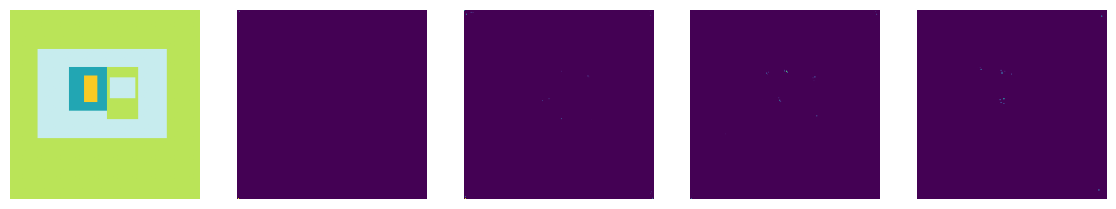

In [31]:
with torch.inference_mode():
    image, annotation = train_dataset[5]
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 7, 1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
    
    output = model(image)
    
    for i, out in enumerate(output):
        plt.subplot(1, 7, i+2)
    
        plt.imshow(out.detach().cpu().squeeze())
        # plt.imshow(annotation[i])
        plt.axis("off")

# LSTM Cell

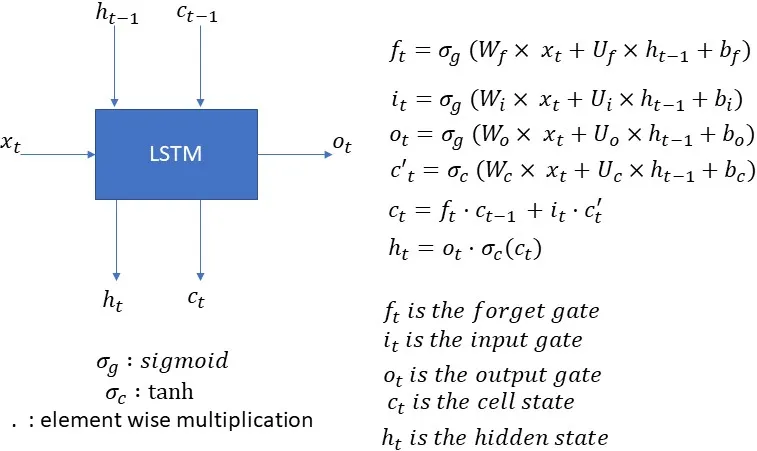

In [90]:
class RLSTMCell(nn.Module):
    def __init__(self, in_channels, height, width, out_channels=1, cell_unit = UnitProcess):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden and cell states
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden_state', torch.ones(1, in_channels, height, width))
        self.register_buffer('cell_state', torch.ones(1, out_channels, height, width))
        self.hidden_state = self.hidden_state.to("cuda")
        self.cell_state = self.cell_state.to("cuda")
        
        # forget gate
        self.Wf = cell_unit(in_channels, out_channels)
        self.Uf = cell_unit(in_channels, out_channels)
        
        # input gate
        self.Wi = cell_unit(in_channels, out_channels)
        self.Ui = cell_unit(in_channels, out_channels)
        
        # output gate
        self.Wo = cell_unit(in_channels, out_channels)
        self.Uo = cell_unit(in_channels, out_channels)
        
        # cell state
        self.Wc = cell_unit(in_channels, out_channels)
        self.Uc = cell_unit(in_channels, out_channels)
               
        
    def forward(self, x):
        # forget gate
        f_t = nn.functional.sigmoid(self.Wf(x) + self.Uf(self.hidden_state))
        
        # input gate
        i_t = nn.functional.sigmoid(self.Wi(x) + self.Ui(self.hidden_state))
        
        # output gate
        o_t = nn.functional.sigmoid(self.Wo(x) + self.Uo(self.hidden_state))
        
        # cell state
        c_t_prime = nn.functional.relu(self.Wc(x) + self.Uc(self.hidden_state))
        self.cell_state = f_t * self.cell_state + i_t * c_t_prime
        
        # hidden state
        self.hidden_state = o_t * nn.functional.relu(self.cell_state)
        
        return o_t
    
    def resetState(self):
        self.hidden_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")
        self.cell_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

In [37]:
# test 
model = RLSTMCell(3, 200, 200).cuda()
model(torch.rand(1, 3, 200, 200).cuda()).shape

# test
model = RCNN(rcnn_cell=lambda *x: RLSTMCell(*x),
             n_cells=4,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
[i.shape for i in model([torch.randn(1, 3, 200, 200).to("cuda") for _ in range(3)])]

[torch.Size([1, 1, 200, 200]),
 torch.Size([1, 1, 200, 200]),
 torch.Size([1, 1, 200, 200])]

In [64]:
dataset = BaseHISDataset("../data/dataset_3/data/", "../data/dataset_3/RCNNAnnotations/")
train_dataset, val_dataset = random_split(
    dataset, [45, 5], torch.Generator().manual_seed(10)
)

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RCNN(rcnn_cell=lambda *x: RLSTMCell(*x),
             n_cells=3,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.).to("cuda"))
in_channels = 3
height = 200
width = 200
writer = SummaryWriter(f"./runs/RCNNGroup/LSTM/d2/r2", comment="RCNN, batch increasing, 4 cells")

In [39]:
random.choice(range(10))

0

In [123]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
batch_size = 1
for e in range(100, 150):
    
    epoch_loss = 0
    optimizer.zero_grad()
    for b, data in enumerate(train_dataset):
        image, annotation = data
        # pass input
        optimizer.zero_grad()
        
        image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
        
        output = model(image)
        
        # each iteration randomly optimze on one
        idx = random.choice(range(len(annotation)))
        ann = torch.tensor(annotation[idx]).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
        l = loss(output[idx], ann)
        
        # compute loss
        # l = 0
        # for i, ann in enumerate(annotation):
        #     # loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float((i+1))).to("cuda"))
        #     ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
        #     l += loss(output[i], ann) #* (weight+1)
        
            
        
        # print(b)
        l.backward()
        optimizer.step()
        
        # print(f"{b}%{batch_size} = {i%batch_size}")
        # if b%batch_size == 0:
        #     optimizer.step()
        
        epoch_loss += l 
    
    writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"Epoch {e}: {epoch_loss}")

Epoch 100: 33.47149019448453
Epoch 101: 35.05760786477344
Epoch 102: 34.44317076521653
Epoch 103: 34.01524332952105
Epoch 104: 35.19327550574322
Epoch 105: 34.03589858136644
Epoch 106: 34.33071404345715
Epoch 107: 34.42049387495035
Epoch 108: 34.22978059599446
Epoch 109: 34.42350918169949
Epoch 110: 33.28155882459715
Epoch 111: 34.395010354357076
Epoch 112: 34.02807268812392
Epoch 113: 33.76259364161372
Epoch 114: 33.79691678368518
Epoch 115: 34.26710415909306
Epoch 116: 33.877601931470366
Epoch 117: 34.33605501528044
Epoch 118: 33.64812415549868
Epoch 119: 34.305497306944524
Epoch 120: 33.317266729551754
Epoch 121: 34.41426619573449
Epoch 122: 33.47497806938738
Epoch 123: 34.602750143050535
Epoch 124: 34.186860251611655
Epoch 125: 34.16717339420473
Epoch 126: 33.58475879480487
Epoch 127: 34.53514345134047
Epoch 128: 33.436498969128046
Epoch 129: 34.64445397292341
Epoch 130: 33.00809842606091
Epoch 131: 34.4713749574609
Epoch 132: 34.13908088421884
Epoch 133: 34.695605154552545
Epoch 1

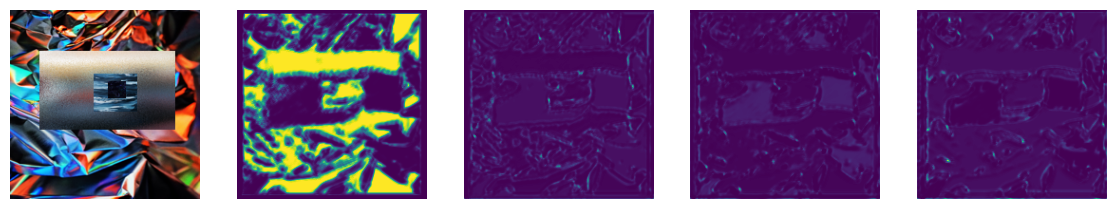

In [124]:
with torch.inference_mode():
    image, annotation = train_dataset[9]
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 7, 1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    
    image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
    
    output = model(image)
    
    for i, out in enumerate(output):
        plt.subplot(1, 7, i+2)
    
        plt.imshow(out.detach().cpu().squeeze())
        # plt.imshow(annotation[i])
        plt.axis("off")

# U-Net like RNN

In [3]:
class UnitProcess2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.Conv2d(out_channels, out_channels, 3, 1, 1),
          nn.BatchNorm2d(out_channels),
        )
        
        
    def forward(self, x):
        return self.process(x)
    

In [8]:
class RLSTMCell(nn.Module):
    def __init__(self, in_channels, height, width, out_channels=1, cell_unit = UnitProcess2):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden and cell states
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden_state', torch.ones(1, in_channels, height, width))
        self.register_buffer('cell_state', torch.ones(1, in_channels, height, width))
        self.hidden_state = self.hidden_state.to("cuda")
        self.cell_state = self.cell_state.to("cuda")
        
        # forget gate
        self.Wf = cell_unit(in_channels, out_channels)
        self.Uf = cell_unit(in_channels, out_channels)
        
        # input gate
        self.Wi = cell_unit(in_channels, out_channels)
        self.Ui = cell_unit(in_channels, out_channels)
        
        # output gate
        self.Wo = cell_unit(in_channels, out_channels)
        self.Uo = cell_unit(in_channels, out_channels)
        
        # cell state
        self.Wc = cell_unit(in_channels, out_channels)
        self.Uc = cell_unit(in_channels, out_channels)
               
        
    def forward(self, x):
        # forget gate
        f_t = nn.functional.sigmoid(self.Wf(x) + self.Uf(self.hidden_state))
        
        # input gate
        i_t = nn.functional.sigmoid(self.Wi(x) + self.Ui(self.hidden_state))
        
        # output gate
        o_t = nn.functional.sigmoid(self.Wo(x) + self.Uo(self.hidden_state))
        
        # cell state
        c_t_prime = nn.functional.relu(self.Wc(x) + self.Uc(self.hidden_state))
        self.cell_state = f_t * self.cell_state + i_t * c_t_prime
        
        # hidden state
        self.hidden_state = o_t * nn.functional.relu(self.cell_state)
        
        return o_t
    
    def resetState(self):
        self.hidden_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")
        self.cell_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

In [9]:
class RCNNCustomizable(nn.Module):
    def __init__(self, rcnn_cell, in_channels, height, width, features=[64, 128, 512], out_channels=1):
        super().__init__()
        
        self.features = features
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = 1
        
        self.down = nn.ModuleList()
        # self.up = nn.ModuleList()
        
        # down scaling pass
        in_feature = in_channels
        for i, feature in enumerate(features):
            mul = (1/2*i)
            self.down.append(
                nn.Sequential(
                    rcnn_cell(in_feature, 
                              int(height*mul) if mul != 0 else height, 
                              int(width*mul) if mul != 0 else width, 
                              feature),
                    nn.MaxPool2d(2, 2)   
                )
                )
            # self.down.append(rcnn_cell(in_feature, height//((i+1)*2), width//((i+1)*2), feature))
            # self.down.append(nn.MaxPool2d(2, 2, 2))
            in_feature = feature
        
        # up scaling pass
        in_feature = features[-1]
        features_up = list(reversed(features))
        features_up = features_up[1:] + [out_channels]
        for i, feature in enumerate(reversed(features)):
            self.down.append(
                nn.Sequential(
                    nn.ConvTranspose2d(feature, feature, 2, 2),
                    rcnn_cell(in_feature,
                                     int(height * (1/2*(len(features)-(i+1)))),
                                     int(width * (1/2*(len(features)-(i+1)))),
                                     feature)
                )
            )
            # self.down.append(nn.ConvTranspose2d(feature, feature, 2, 2))
            # self.down.append(rcnn_cell(in_feature,
            #                          int(height * (1/2*(len(features)-(i+1)))),
            #                          int(width * (1/2*(len(features)-(i+1)))),
            #                          feature))
            in_feature = feature
        
        

    def forward(self, x):
        """
        x: list of tokens (c, h, w)
        """
        # reset all cell states for new input
        for cell in self.down:
            if "resetState" in cell.__dir__():
                cell.resetState()
        
        # keep feed layer output to next layer
        layer_input = x
        layer_output = []
        for i, cell in enumerate(self.down):
            # generating output for nth cell
            for input_t in layer_input:
                print("in", input_t.shape, cell[0])
                out = cell[0](input_t)
                layer_output.append(out)
                print("out", out.shape)
                
            print("next")
            # output becomes input
            layer_input = layer_output
            if i+1 < len(self.rcnn_cells):
                layer_output = []
                
        return layer_output

In [45]:
2*4 or 3

8

In [48]:
class RCNNCustomizable(nn.Module):
    def __init__(self, rcnn_cell, in_channels, height, width, features=[64, 128, 512], out_channels=1):
        super().__init__()
        
        self.features = features
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = 1
        
        self.down = nn.ModuleList()
        
        # down scaling pass
        in_feature = in_channels
        for i, feature in enumerate(features):
            self.down.append(nn.Sequential(
                nn.Conv2d(in_feature, feature, 1),
                rcnn_cell(feature, height//(2*i or 1), width//(2*i or 1), feature),
                nn.MaxPool2d(2,2)
            ))
            in_feature = feature
            
        
        # up scaling
        # in_feature = features[-1]
        # for i, feature in enumerate(reversed(features)):
        #     self.down.append(nn.Sequential(
        #         nn.ConvTranspose2d(in_feature, in_feature, 2, 2),
        #         rcnn_cell(feature, )
        #     ))
        
        

    def forward(self, x):
        """
        x: list of tokens (c, h, w)
        """
        # reset all cell states for new input
        for cell in self.down:
            if "resetState" in cell.__dir__():
                cell.resetState()
        
        # keep feed layer output to next layer
        layer_input = x
        layer_output = []
        for i, cell in enumerate(self.down):
            for input_t in layer_input:
                layer_output.append(cell(input_t))
             
            print([i.shape for i in layer_output])
            layer_input = layer_output
            if i+1 < len(self.down):
                layer_output = []
            

        return layer_output

In [49]:
# test 
model = RLSTMCell(3, 200, 200).cuda()
model(torch.rand(1, 3, 200, 200).cuda()).shape

# test
model = RCNNCustomizable(rcnn_cell=lambda *x: RLSTMCell(*x, cell_unit=UnitProcess2),
    features=[4, 8, 16],
    in_channels=3,
    height=200,
    width=200,
    out_channels=1).to("cuda")
[i.shape for i in model([torch.randn(1, 3, 200, 200).to("cuda") for _ in range(3)])]

[torch.Size([1, 4, 100, 100]), torch.Size([1, 4, 100, 100]), torch.Size([1, 4, 100, 100])]
[torch.Size([1, 8, 50, 50]), torch.Size([1, 8, 50, 50]), torch.Size([1, 8, 50, 50])]
[torch.Size([1, 16, 25, 25]), torch.Size([1, 16, 25, 25]), torch.Size([1, 16, 25, 25])]


[torch.Size([1, 16, 25, 25]),
 torch.Size([1, 16, 25, 25]),
 torch.Size([1, 16, 25, 25])]

In [53]:
[m for m in model.down][2]

RLSTMCell(
  (Wf): UnitProcess(
    (process): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (Uf): UnitProcess(
    (process): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), st